<a href="https://colab.research.google.com/github/bannis14/Portfolio-Projects/blob/main/Volkswagen_Causal_Impact_Analysis/Volkswagen_Deiselgate_Stock_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Volkswagen Deiselgate Stock Price Analysis



  ## Our Goal:

  This Colab notebook aims to analyze the potential causal impact of the Volkswagen (VW) emission scandal on the stock price of VW. In the causal impact analysis below we seek to understand whether the revelation of the emission scandal had a discernible influence on the stock performance of VW.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libraries and Data

In [ ]:
! pip install pycausalimpact

In [ ]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
from causalimpact import CausalImpact
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing

In [ ]:
# Define key dates
training_start = "2014-01-02"
training_end = "2015-08-26"
treatment_start = "2015-09-02"
treatment_end = "2015-09-30"
end_stock = "2015-10-01"

In [ ]:
# Download VW stock data
y = ["VOW.DE"]
y = yf.download(tickers=y, start=training_start, end=end_stock, interval="1wk", ignore_tz=True)
y = y['Adj Close'].rename("VW Stock Price")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Download other stock data
stocks = ["T","WFC","AAPL","PM","LLY","LMT"]
X = yf.download(tickers=stocks, start=training_start, end=end_stock, interval="1wk", ignore_tz=True)

[*********************100%%**********************]  6 of 6 completed


In [ ]:
# Display sample data
y.head()
X.head()

Adj Close                                                          \
                 AAPL        LLY         LMT         PM          T        WFC   
Date                                                                            
2014-01-01  16.931154  41.296600  113.777191  51.638618  12.452763  34.313332   
2014-01-08  17.130238  42.305023  115.928566  50.278755  11.928995  34.456940   
2014-01-15  17.214262  44.846226  117.980408  51.217865  12.173193  35.144707   
2014-01-22  15.879622  43.749069  113.524559  49.278683  12.220335  34.736588   
2014-01-29  15.951413  42.837467  113.447990  46.882122  11.767057  33.837170   

                Close                                    ...        Open  \
                 AAPL        LLY         LMT         PM  ...         LMT   
Date                                                     ...               
2014-01-01  19.287144  51.189999  148.610001  84.680000  ...  147.050003   
2014-01-08  19.513929  52.439999  151.419998  82.449997  ...  148.389999   
2014-01-15  19.609644  55.590000  154.100006  83.989998  ...  151.419998   
2014-01-22  18.089287  54.230000  148.279999  80.809998  ...  155.000000   
2014-01-29  18.171070  53.099998  148.179993  76.879997  ...  147.139999   

                                                 Volume                      \
                   PM          T        WFC        AAPL       LLY       LMT   
Date                                                                          
2014-01-01  87.000000  26.616314  45.150002  1356972400  22439700   4778200   
2014-01-08  84.500000  26.019636  45.400002  1553708800  29668700  10139900   
2014-01-15  82.449997  25.422960  45.939999  1376183200  34060900   7963800   
2014-01-22  83.919998  25.377644  46.740002  2832981200  26565600  15614300   
2014-01-29  80.470001  24.471298  45.630001  2424254000  35806000  11563000   

                                            
                  PM          T        WFC  
Date                                        
2014-01-01  20421400  120966995   67362800  
2014-01-08  39746200  200366745   99905700  
2014-01-15  23091700  126268027   70989200  
2014-01-22  27371700  181789171   89198800  
2014-01-29  43139800  331502193  110588600  

[5 rows x 36 columns]

In [ ]:
# Clean up and prepare the data
X = X.iloc[:, : len(stocks)]
X.columns = X.columns.droplevel()

In [ ]:
# Combine the data into a single DataFrame
df = pd.concat([y, X], axis=1).dropna()

In [ ]:
# Display a sample of the combined data
df.head()

,VW Stock Price,AAPL,LLY,LMT,PM,T,WFC
Date,,,,,,,
2014-01-01,124.750298,16.931154,41.296600,113.777191,51.638618,12.452763,34.313332
2014-01-08,122.623314,17.130238,42.305023,115.928566,50.278755,11.928995,34.456940
2014-01-15,126.812836,17.214262,44.846226,117.980408,51.217865,12.173193,35.144707
2014-01-22,120.786392,15.879622,43.749069,113.524559,49.278683,12.220335,34.736588
2014-01-29,113.116386,15.951413,42.837467,113.447990,46.882122,11.767057,33.837170


In [ ]:
# Extract training data
df_training = df[df.index <= training_end]

In [ ]:
# Display the tail of the training data
df_training.tail()

,VW Stock Price,AAPL,LLY,LMT,PM,T,WFC
Date,,,,,,,
2015-07-29,125.172920,25.897655,71.039192,168.189392,56.175022,13.954730,45.518482
2015-08-05,125.307495,25.637863,70.608177,167.651566,55.939411,13.982974,45.038254
2015-08-12,117.904831,26.436962,70.481361,170.709824,54.990398,13.861917,45.593765
2015-08-19,112.924812,23.541378,66.543777,159.720871,50.651119,12.832863,39.635044
2015-08-26,108.987923,24.444553,67.853210,158.629227,50.906380,13.042713,40.403648


<Axes: >

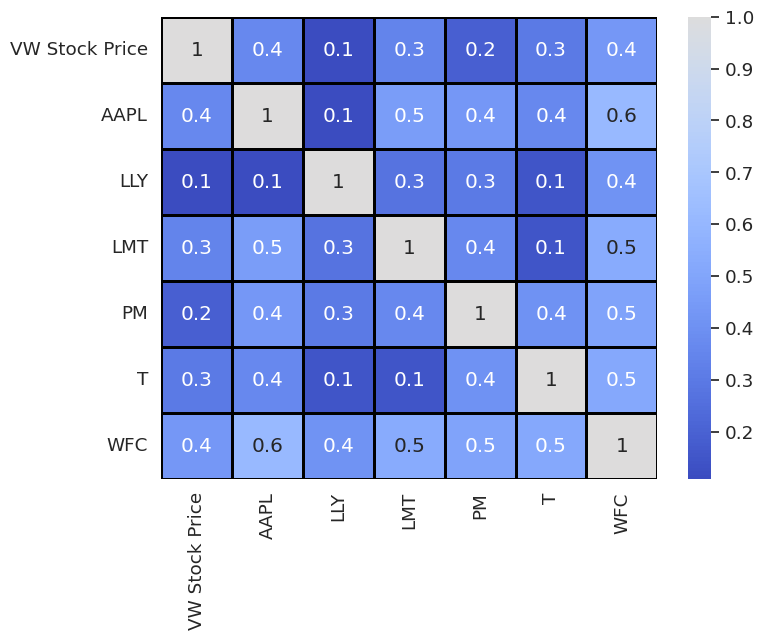

In [ ]:
# Visualize data correlations using a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(data=df_training.pct_change().dropna().corr(),
            annot=True,
            fmt='.1g',
            cmap='coolwarm',
            center=True,
            linecolor='black',
            linewidth=1
            )

In [ ]:
# Drop unwanted columns from the data
df_final = df.drop(columns=['LLY', 'PM'])

In [ ]:
# Define pre and post treatment periods
pre_period = ["2014-01-01", training_end]
post_period = [treatment_start, treatment_end]

## Causal Impact Model

In [ ]:
# Perform causal impact analysis
impact = CausalImpact(data=df_final, pre_period=pre_period, post_period=post_period)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: nseasons, standardize. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: Valu

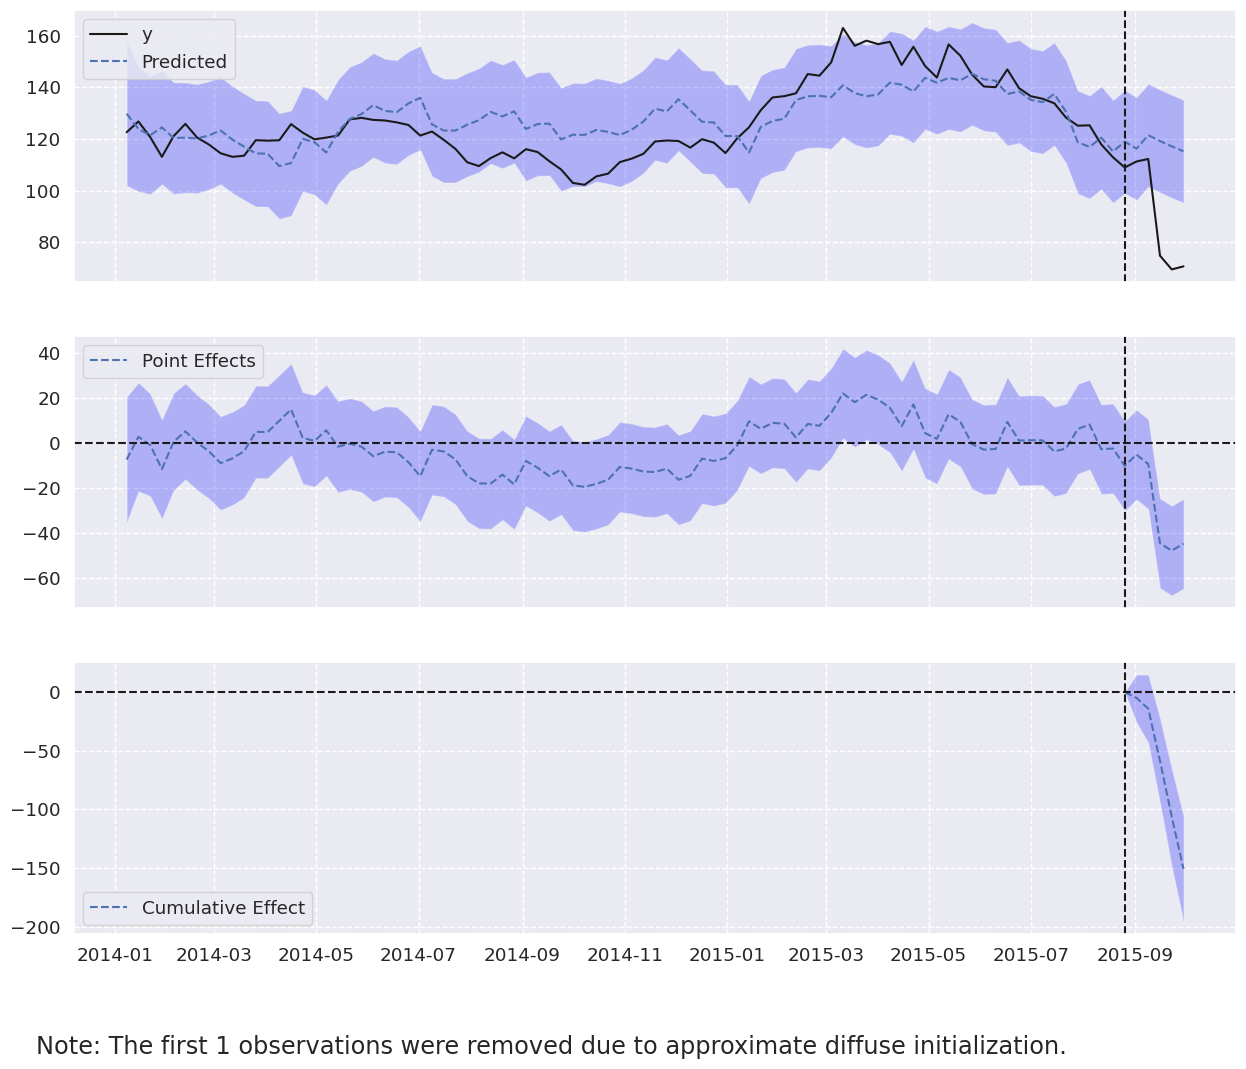

In [ ]:
# Plot the causal impact analysis
impact.plot()

In [ ]:
# Display a summary of the causal impact analysis
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    87.73              438.64
Prediction (s.d.)         117.89 (4.61)      589.45 (23.07)
95% CI                    [108.8, 126.89]    [544.02, 634.46]

Absolute effect (s.d.)    -30.16 (4.61)      -150.81 (23.07)
95% CI                    [-39.16, -21.08]   [-195.81, -105.38]

Relative effect (s.d.)    -25.58% (3.91%)    -25.58% (3.91%)
95% CI                    [-33.22%, -17.88%] [-33.22%, -17.88%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


## Conclusion

In [ ]:
# Display a report-style summary of the analysis
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 87.73. By contrast, in the absence of an
intervention, we would have expected an average response of 117.89.
The 95% interval of this counterfactual prediction is [108.8, 126.89].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -30.16 with a 95% interval of
[-39.16, -21.08]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 438.64.
By contrast, had the intervention not taken place, we would have expected
a sum of 589.45. The 95% interval of this prediction is [544.02, 634.46].


The above results are given in terms of absolute numbers. In relative
terms, the response v